In [1]:
from command_planning import MapReader
from path_finding import PathPlanner
import numpy as np
import json
import matplotlib.pyplot as plt
import time
from diagonal_path_planner import DiagonalPathPlanner
from straight_path_planner import StraightPathPlanner  # Import the correct class
from grid_path_planner import GridPathPlanner
import os
import math

In [2]:
def find_turning_points(path_x, path_y, threshold_angle=15, min_distance=0.1):
    """
    Find turning points based on the angle between three consecutive points,
    excluding points that are collinear or have very small angles.
    
    path_x: List of x-coordinates of the waypoints.
    path_y: List of y-coordinates of the waypoints.
    threshold_angle: Angle threshold in degrees to determine turning points.
    min_distance: Minimum distance between waypoints to consider for turning.

    Returns:
        turning_points_x: List of x-coordinates of the turning points.
        turning_points_y: List of y-coordinates of the turning points.
    """
    if len(path_x) < 3:
        # If there are fewer than 3 points, no turning points can be found
        return [], []

    turning_points_x = [path_x[0]]  # Start with the first point
    turning_points_y = [path_y[0]]

    def angle_between(p1, p2, p3):
        """Calculate the angle between three points (p1, p2, p3)."""
        v1 = (p1[0] - p2[0], p1[1] - p2[1])  # Vector 1: p1 -> p2
        v2 = (p3[0] - p2[0], p3[1] - p2[1])  # Vector 2: p2 -> p3
        dot_product = v1[0] * v2[0] + v1[1] * v2[1]
        mag_v1 = math.hypot(v1[0], v1[1])
        mag_v2 = math.hypot(v2[0], v2[1])
        if mag_v1 == 0 or mag_v2 == 0:
            return 0
        cos_theta = dot_product / (mag_v1 * mag_v2)
        return math.acos(cos_theta) * 180 / math.pi

    def are_points_collinear(p1, p2, p3, tolerance=1e-6):
        """Check if three points are collinear (i.e., they lie on the same straight line)."""
        # Using the slope formula to check if the points are aligned
        # (y2 - y1) / (x2 - x1) should be equal to (y3 - y2) / (x3 - x2)
        # This avoids division by zero, and we just cross-multiply to check for collinearity
        return abs((p2[1] - p1[1]) * (p3[0] - p2[0]) - (p3[1] - p2[1]) * (p2[0] - p1[0])) < tolerance

    # Iterate over the waypoints and find turning points
    for i in range(1, len(path_x) - 1):
        x1, y1 = path_x[i - 1], path_y[i - 1]
        x2, y2 = path_x[i], path_y[i]
        x3, y3 = path_x[i + 1], path_y[i + 1]

        # Check if the three points are collinear
        if are_points_collinear((x1, y1), (x2, y2), (x3, y3)):
            continue  # Skip if they are collinear

        # Calculate angle between points
        angle_diff = angle_between((x1, y1), (x2, y2), (x3, y3))

        # Only consider turning points if the angle is above the threshold
        dist1 = math.hypot(x2 - x1, y2 - y1)
        dist2 = math.hypot(x3 - x2, y3 - y2)

        if angle_diff > threshold_angle and dist1 > min_distance and dist2 > min_distance:
            turning_points_x.append(x2)
            turning_points_y.append(y2)

    # Append the final point
    turning_points_x.append(path_x[-1])
    turning_points_y.append(path_y[-1])

    return turning_points_x, turning_points_y

In [5]:
def main():
    print("Path planning initialized...")

    mapReader = MapReader(map_fname=r'C:\Users\Asus\Desktop\Monash year3\ece4078\milestone1\truemap_cv.txt', search_list=r'C:\Users\Asus\Desktop\Monash year3\ece4078\milestone1\search_list.txt')

    fruits, fruit_positions, aruco_positions = mapReader.load_map_data()
    print(fruits)

    start_x, start_y = 0, 0  # starting position

    search_targets = mapReader.read_search_list()
    goals = PathPlanner.compute_goal_positions(fruits, fruit_positions, search_targets)
    print(search_targets)
    print(goals)
    
    # Use DiagonalPathPlanner instead of PathPlanner
    planner = DiagonalPathPlanner(grid_resolution=0.1, robot_radius=0.17, target_radius=3)

    planner.add_obstacles(fruit_positions, aruco_positions, obstacle_size=0.1)  # Add obstacles
    
    goal_count = 0
    show_visualization = True

    with open('waypoint.txt', 'w') as file:  # Open file once in write mode
        for goal in goals:
            goal_count += 1
            # Use the planner to generate the path
            smoothed_x, smoothed_y = planner.plan_path_based_mode(start_x, start_y, goal[0], goal[1])
            print(f"path x: {smoothed_x[::-1]},\n path y: {smoothed_y[::-1]}")
            print(goal)

            # Find turning points
            turning_x, turning_y = find_turning_points(smoothed_x, smoothed_y, threshold_angle=15)

            if show_visualization:
                # Plot the obstacles
                plt.plot(planner.obstacle_x, planner.obstacle_y, ".k")

                # Plot the paths
                plt.plot(smoothed_x, smoothed_y, "-r", label='Path')
                
                # Plot the start position
                plt.plot(start_x, start_y, "og", markersize=10, label='Start Position')  # 'og' is green circle

                # Plot the goal position
                plt.plot(goal[0], goal[1], "xb", label='Goal Position')

                # Plot each waypoint along the path
                for x, y in zip(smoothed_x, smoothed_y):
                    plt.plot(x, y, 'or')  # Mark each waypoint with a red circle
                
                # Plot the turning points
                for x, y in zip(turning_x, turning_y):
                    plt.plot(x, y, 'oc', markersize=8, label='Turning Point')  # Mark turning points with a cyan circle

                # Final setup for the plot
                plt.grid(True)
                plt.axis("equal")
                plt.plot(smoothed_x, smoothed_y, "-r")
                plt.gca().set_xticks(np.arange(-1.6, 1.6, 0.4))
                plt.gca().set_yticks(np.arange(-1.6, 1.6, 0.4))
                plt.xlim(-1.6, 1.6)
                plt.ylim(-1.6, 1.6)
                plt.show()

            # Write waypoints to file
            file.write(f"Target {goal_count}\n")
            for x, y in zip(smoothed_x, smoothed_y):
                file.write(f"{x},{y}\n")

            # Write turning points to file (optional)
            file.write("Turning Points:\n")
            for tx, ty in zip(turning_x, turning_y):
                file.write(f"{tx},{ty}\n")

            # Update the start position for the next iteration
            start_x, start_y = smoothed_x[0], smoothed_y[0]


Path planning initialized...
['redapple', 'greenapple', 'orange', 'mango', 'capsicum']
['capsicum', 'mango', 'redapple', 'greenapple', 'orange']
[array([ 0.8, -0.4]), array([-0.8, -1.2]), array([0. , 0.6]), array([-1.2,  0.2]), array([1.2, 1. ])]
time to add obstacles 0.0
time to build grid 0.132049560546875
time to add obstacles 0.0
time to build grid 0.06992125511169434
time to add obstacles 0.005547761917114258
time to build grid 0.0573582649230957
time to add obstacles 0.0
time to build grid 0.053533077239990234
time to add obstacles 0.0
time to build grid 0.057663679122924805
time to add obstacles 0.0
time to build grid 0.05512642860412598
time to add obstacles 0.0
time to build grid 0.05405902862548828
time to add obstacles 0.0
time to build grid 0.06015920639038086
time to add obstacles 0.0005486011505126953
time to build grid 0.05381917953491211
time to add obstacles 0.0
time to build grid 0.06498503684997559
time to add obstacles 0.0
time to build grid 0.059655189514160156
tim

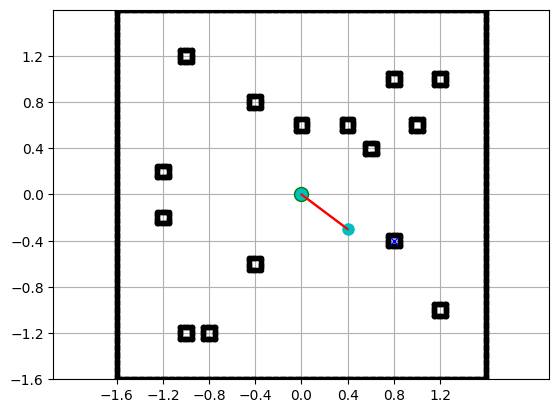

Navigation Time: 0.0010018348693847656
Smoothed Path X, Y:
(0.40, -0.30)
(0.40, -0.30)
(-0.40, -1.10)
path x: [0.40000000000000036, 0.40000000000000036, -0.3999999999999999],
 path y: [-0.2999999999999998, -0.2999999999999998, -1.1]
[-0.8 -1.2]


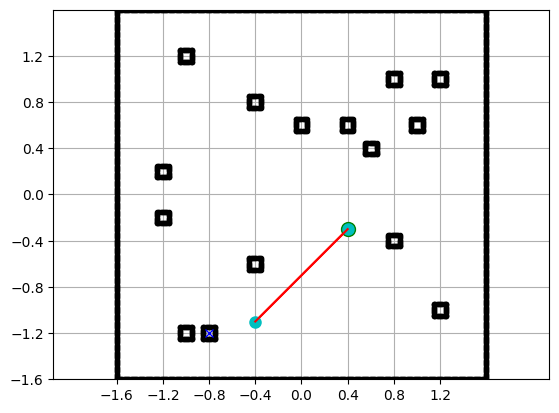

Navigation Time: 0.0009970664978027344
Smoothed Path X, Y:
(-0.40, -1.10)
(-0.40, -1.10)
(-0.10, -0.80)
(0.00, 0.20)
path x: [-0.3999999999999999, -0.3999999999999999, -0.09999999999999987, 0.0],
 path y: [-1.1, -1.1, -0.7999999999999998, 0.20000000000000018]
[0.  0.6]


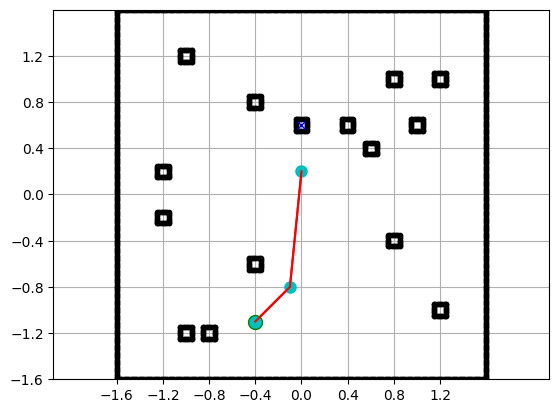

Navigation Time: 0.0015106201171875
Smoothed Path X, Y:
(0.00, 0.20)
(0.00, 0.20)
(-0.80, 0.20)
path x: [0.0, 0.0, -0.7999999999999998],
 path y: [0.20000000000000018, 0.20000000000000018, 0.20000000000000018]
[-1.2  0.2]


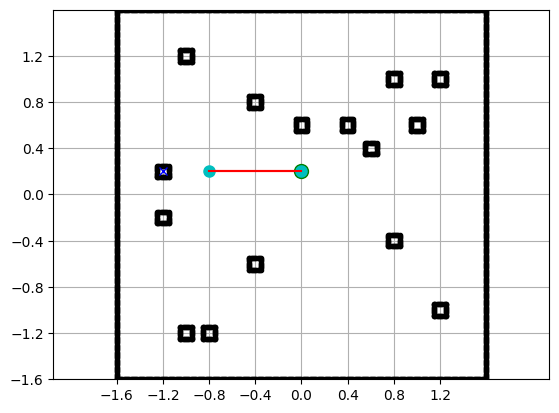

Navigation Time: 0.01206350326538086
Smoothed Path X, Y:
(-0.80, 0.20)
(-0.80, 0.20)
(-0.70, 1.00)
(-0.60, 1.10)
(0.60, 1.30)
(1.10, 1.30)
path x: [-0.7999999999999998, -0.7999999999999998, -0.7, -0.5999999999999999, 0.6000000000000001, 1.1],
 path y: [0.20000000000000018, 0.20000000000000018, 1.0, 1.1, 1.3000000000000003, 1.3000000000000003]
[1.2 1. ]


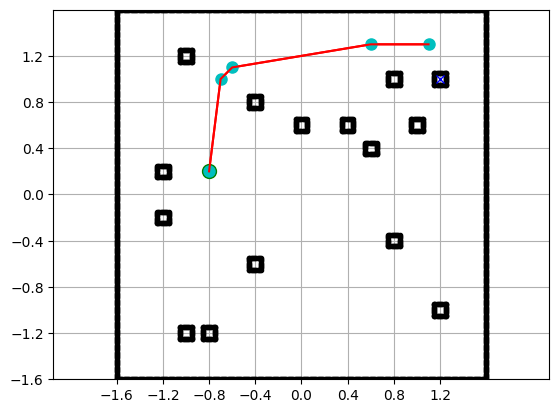

In [6]:
main()

In [5]:
def main():
    print("Path planning initialized...")

    mapReader = MapReader(map_fname=r'C:\Users\Asus\Desktop\Monash year3\ece4078\milestone1\truemap_cv.txt', search_list=r'C:\Users\Asus\Desktop\Monash year3\ece4078\milestone1\search_list.txt')

    fruits, fruit_positions, aruco_positions = mapReader.load_map_data()
    print(fruits)

    start_x, start_y = 0, 0  # starting position

    search_targets = mapReader.read_search_list()
    goals = PathPlanner.compute_goal_positions(fruits, fruit_positions, search_targets)
    print(search_targets)
    print(goals)
    

    # Use StraightPathPlanner instead of PathPlanner
    planner = StraightPathPlanner(grid_resolution=0.1, robot_radius=0.1, target_radius=3.7)

    planner.add_obstacles(fruit_positions, aruco_positions, obstacle_size=0.1)  # Add obstacles
        
    goal_count = 0
    show_visualization = True

    with open('waypoint.txt', 'w') as file:  # Open file once in write mode
        for goal in goals:
            goal_count += 1
            # Use the planner to generate the path
            smoothed_x, smoothed_y = planner.plan_path_based_mode(start_x, start_y, goal[0], goal[1])
            print(f"path x: {smoothed_x[::-1]},\n path y: {smoothed_y[::-1]}")
            print(goal)

            # Find turning points
            turning_x, turning_y = find_turning_points(smoothed_x, smoothed_y, threshold_angle=30)

            if show_visualization:
                # Plot the obstacles
                plt.plot(planner.obstacle_x, planner.obstacle_y, ".k")

                # Plot the paths
                plt.plot(smoothed_x, smoothed_y, "-r", label='Path')
                
                # Plot the start position
                plt.plot(start_x, start_y, "og", markersize=10, label='Start Position')  # 'og' is green circle

                # Plot the goal position
                plt.plot(goal[0], goal[1], "xb", label='Goal Position')

                # Plot each waypoint along the path
                for x, y in zip(smoothed_x, smoothed_y):
                    plt.plot(x, y, 'or')  # Mark each waypoint with a red circle
                
                # Plot the turning points
                for x, y in zip(turning_x, turning_y):
                    plt.plot(x, y, 'oc', markersize=8, label='Turning Point')  # Mark turning points with a cyan circle

                # Final setup for the plot
                plt.grid(True)
                plt.axis("equal")
                plt.plot(smoothed_x, smoothed_y, "-r")
                plt.gca().set_xticks(np.arange(-1.6, 1.6, 0.4))
                plt.gca().set_yticks(np.arange(-1.6, 1.6, 0.4))
                plt.xlim(-1.6, 1.6)
                plt.ylim(-1.6, 1.6)
                plt.show()

            # Write waypoints to file
            file.write(f"Target {goal_count}\n")
            for x, y in zip(smoothed_x, smoothed_y):
                file.write(f"{x},{y}\n")

            # Write turning points to file (optional)
            file.write("Turning Points:\n")
            for tx, ty in zip(turning_x, turning_y):
                file.write(f"{tx},{ty}\n")

            # Update the start position for the next iteration
            start_x, start_y = smoothed_x[0], smoothed_y[0]

Path planning initialized...
['redapple', 'greenapple', 'orange', 'mango', 'capsicum']
['capsicum', 'mango', 'redapple', 'greenapple', 'orange']
[array([ 0.8, -0.4]), array([-0.8, -1.2]), array([0. , 0.6]), array([-1.2,  0.2]), array([1.2, 1. ])]
time to add obstacles 0.0
time to build grid 1.052617073059082
time to add obstacles 0.0009975433349609375
time to build grid 1.119471788406372
time to add obstacles 0.0
time to build grid 1.2192778587341309
time to add obstacles 0.0
time to build grid 1.1384124755859375
time to add obstacles 0.0
time to build grid 1.5308470726013184
time to add obstacles 0.0
time to build grid 2.351966619491577
time to add obstacles 0.0
time to build grid 1.2575559616088867
time to add obstacles 0.0
time to build grid 1.4572956562042236
time to add obstacles 0.0
time to build grid 1.2037220001220703
time to add obstacles 0.0
time to build grid 1.2522780895233154
time to add obstacles 0.0
time to build grid 1.3036394119262695
time to add obstacles 0.0
time to 

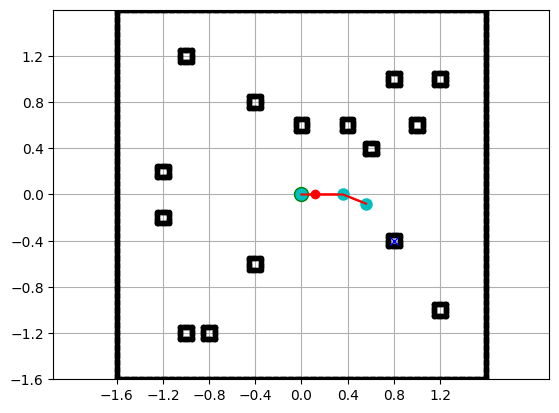

path x: [0.6000000000000001, 0.5600000000000005, 0.5600000000000005, 0.5600000000000005, 0.5600000000000005, 0.4800000000000004, 0.24000000000000155, 2.220446049250313e-15, -0.23999999999999688, -0.47999999999999643],
 path y: [-0.09999999999999987, -0.13999999999999968, -0.379999999999999, -0.5799999999999992, -0.7799999999999994, -0.9799999999999995, -0.9799999999999995, -0.9799999999999995, -0.9799999999999995, -0.9799999999999995]
[-0.8 -1.2]


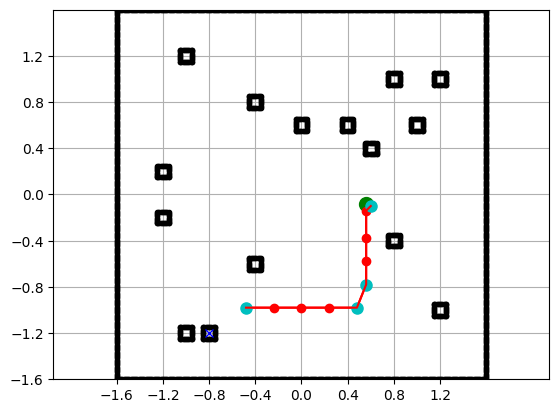

path x: [-0.5, -0.45999999999999996, -0.3400000000000001, -0.1800000000000006, -0.1800000000000006, -0.1800000000000006, -0.1800000000000006, -0.1800000000000006],
 path y: [-1.0, -1.0, -0.8399999999999999, -0.6799999999999997, -0.47999999999999954, -0.2400000000000002, -8.881784197001252e-16, 0.239999999999998]
[0.  0.6]


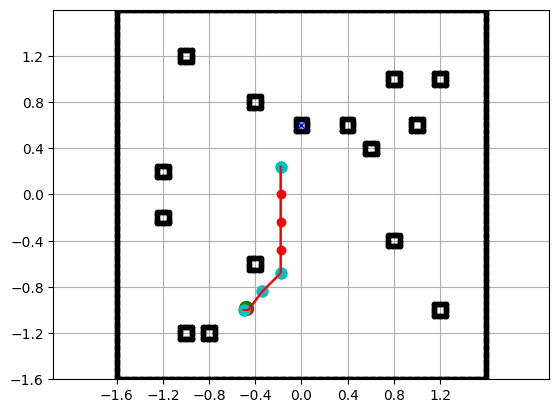

path x: [-0.19999999999999996, -0.39999999999999925, -0.5999999999999994, -0.7999999999999996],
 path y: [0.20000000000000018, 0.20000000000000018, 0.20000000000000018, 0.20000000000000018]
[-1.2  0.2]


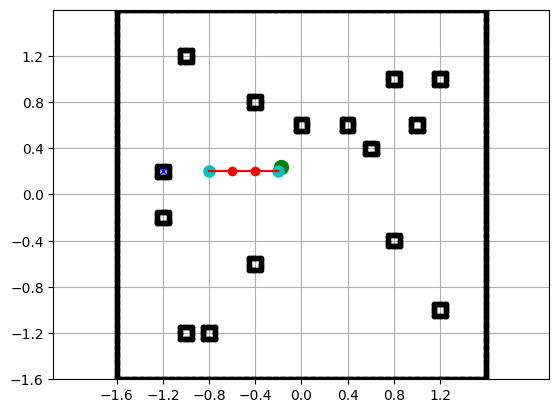

Exception: No path found

In [6]:
main()

In [7]:
def main():
    print("Path planning initialized...")

    mapReader = MapReader(map_fname='truemap_cv.txt', search_list='search_list.txt')

    fruits, fruit_positions, aruco_positions = mapReader.load_map_data()
    print(fruits)

    start_x, start_y = 0, 0  # starting position

    search_targets = mapReader.read_search_list()
    goals = PathPlanner.compute_goal_positions(fruits, fruit_positions, search_targets)
    print(search_targets)
    print(goals)

    # Use StraightPathPlanner instead of PathPlanner
    planner = GridPathPlanner(grid_resolution=0.1, target_radius=0.5, obstacle_size=0.08)

    planner.add_obstacles(fruit_positions, aruco_positions, obstacle_size=0.08)  # Add obstacles
        
    goal_count = 0
    show_visualization = True

    with open('waypoint.txt', 'w') as file:  # Open file once in write mode
        for goal in goals:
            goal_count += 1
            # Use the straight planner to generate the path
            smoothed_x, smoothed_y = planner.plan_path_based_mode(start_x, start_y, goal[0], goal[1])

            print(goal)

            if show_visualization:
                plt.plot(planner.obstacle_x, planner.obstacle_y, ".k")
                plt.plot(start_x, start_y, "og")
                plt.plot(goal[0], goal[1], "xb")
                plt.grid(True)
                plt.axis("equal")
                plt.plot(smoothed_x, smoothed_y, "-r")
                plt.gca().set_xticks(np.arange(-1.6, 1.6, 0.4))
                plt.gca().set_yticks(np.arange(-1.6, 1.6, 0.4))
                plt.xlim(-1.6, 1.6)
                plt.ylim(-1.6, 1.6)
                plt.show()

            # Write waypoints to file
            file.write(f"Target{goal_count}\n")
            for x, y in zip(smoothed_x, smoothed_y):
                file.write(f"{x},{y}\n")

            # Update the start position for the next iteration
            start_x, start_y = smoothed_x[0], smoothed_y[0]

In [8]:
main()

Path planning initialized...


FileNotFoundError: [Errno 2] No such file or directory: 'truemap_cv.txt'

The purpose of this jupyter notebook is to see what is the reason behind slow calculation of algo.Besides, we could also demo the functionality of path_finding package via code above.